# CSC 578 Final Project
### Evelina Ramoskaite
### 11/22/2021


### Setup


In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Loading Data

In [2]:
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

csv_path
# should be '/content/sample_data/Metro_Interstate_reduced.csv'

'/content/sample_data/Metro_Interstate_reduced.csv'

In [3]:
df = pd.read_csv("/content/sample_data/Metro_Interstate_reduced.csv")
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


### Exploratory 

In [4]:
df.shape

(40575, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              40575 non-null  object 
 1   temp                 40575 non-null  float64
 2   rain_1h              40575 non-null  float64
 3   snow_1h              40575 non-null  float64
 4   clouds_all           40575 non-null  int64  
 5   weather_main         40575 non-null  object 
 6   weather_description  40575 non-null  object 
 7   date_time            40575 non-null  object 
 8   traffic_volume       40575 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.8+ MB


In [6]:
# Checking for missing values
df.isnull().any() 

holiday                False
temp                   False
rain_1h                False
snow_1h                False
clouds_all             False
weather_main           False
weather_description    False
date_time              False
traffic_volume         False
dtype: bool

In [7]:
df.describe(include=['float64','int64','object']).transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
holiday,40575,12,None,40522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,40575,NaN,NaN,NaN,281.317,13.8166,0,271.84,282.86,292.28,310.07
rain_1h,40575,NaN,NaN,NaN,0.318632,48.8126,0,0,0,0,9831.3
snow_1h,40575,NaN,NaN,NaN,0.000117314,0.00567615,0,0,0,0,0.51
clouds_all,40575,NaN,NaN,NaN,44.1992,38.6834,0,1,40,90,100
weather_main,40575,11,Clouds,15123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_description,40575,35,sky is clear,11642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_time,40575,40575,2016-06-07 13:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_volume,40575,NaN,NaN,NaN,3290.65,1984.77,0,1248.5,3427,4952,7280


In [8]:
# ER getting the start and end date
print("Start: " +df.date_time.min())
print("End: " +df.date_time.max())

Start: 2012-10-02 09:00:00
End: 2018-09-30 23:00:00


In [9]:
# ER converting the time variable to a datetime type object
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
date_time=df['date_time']
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Types of Weather

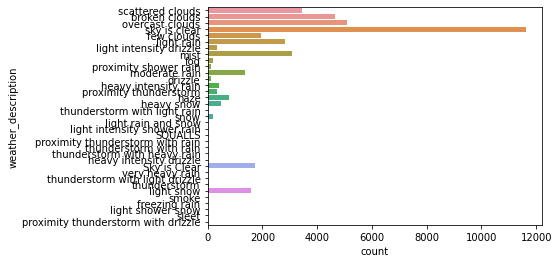

In [10]:
sns.countplot(y='weather_description',data=df)

Main Weather of the Day
Most days were either cloudy or clear. Squall and Smoke were the least common weather types.

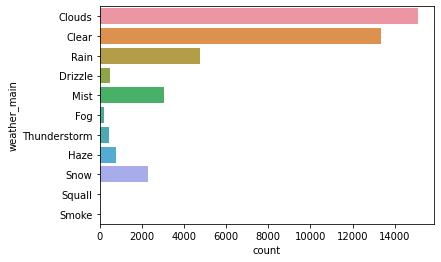

In [11]:
sns.countplot(y='weather_main',data=df)

###Holidays
There are 11 holidays, almost all of which have occured 5 times in the span of the dataset.

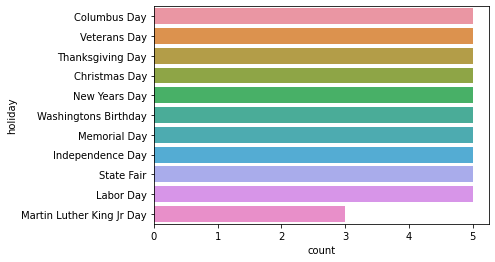

In [12]:
holiday = df[df['holiday']!= 'None']
sns.countplot(y='holiday',data=holiday)

Time Plot 

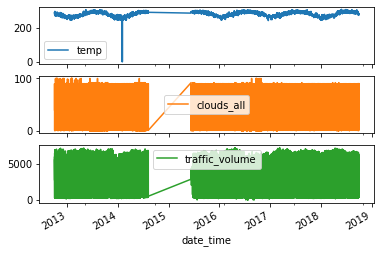

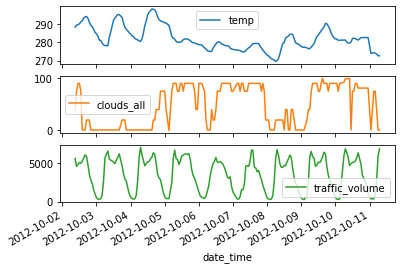

In [13]:
# ER Plotting Columns over time
# TF Tutorial
plot_cols = ['temp','clouds_all','traffic_volume'] 
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:200]
plot_features.index = date_time[:200]
_ = plot_features.plot(subplots=True)

There appears to be a regular seasonality in the traffic volume that could be exploited.Traffic volumes dip at predictable and consistent intervals throughout the week in the last plot.

### Removing Categorical Variables
When the Models included categorical variables, they failed to make predictions. I opted to keep things simple and remove them. 

In [14]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [15]:
# ER determining the number of values to include in the validation set 
40575 * 0.2
df.head()
# Dropping Categorical Variables
df=df.drop(columns=['date_time','weather_description','weather_main','holiday'])


# Train Test Split


In [16]:
# ER leaving out 5,000 values for testing
# ER Testing starts at value 35,575
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:27458]
val_df = df[27459:35574]
test_df= df[35575:]
num_features = df.shape[1]

### Normalizing the Data


In [17]:
# TF Tutorial
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Window Generator


In [18]:
# TF tutorial
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns='traffic_volume'):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Creating Window
The desired window takes 7 input values, and makes 1 prediction 3 hours out into the future.

In [19]:
# ER predict from a 7-hour input window, just the traffic volume for 3 hours past the end of the window. 
# TF tutorial
w1 = WindowGenerator(input_width=7, label_width=1, shift=3,
                     label_columns=['traffic_volume'])
w1

Total window size: 10
Input indices: [0 1 2 3 4 5 6]
Label indices: [9]
Label column name(s): ['traffic_volume']

The window size and indecies of the labels are as expected.

The split window function splits the windows into a window of inputs and a window of labels

In [20]:
# TF tutorial
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Making Tensorflow time series DataFrame
This converts the dataframe into a series of input windows and label windows for use in the models.

In [21]:
# TF Tutorial
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1, # ER changed the stride to 3
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
# TF Tutorial
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

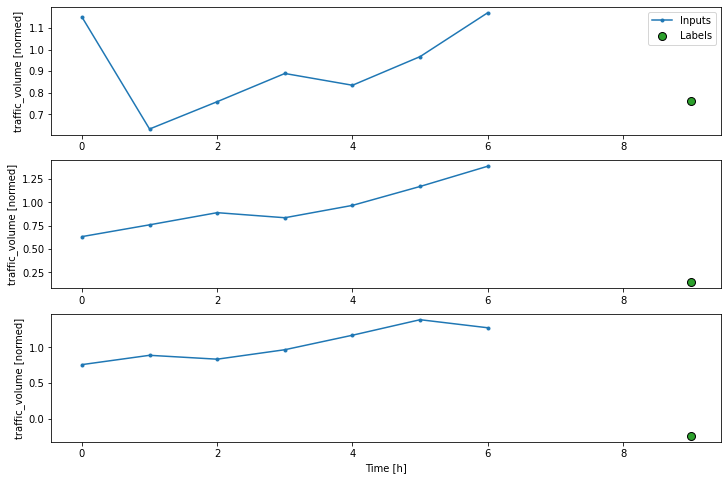

In [24]:
w1.plot()

For the time series, a window is required. The network will make a set of predictions based on a window of consecutive data. In this project, I am using a 7-hour input window and predicting the label for 1 value 3 hours beyond that window. 

### Verifying the input and output shapes

In [25]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Confirming that the ts dataframes have the correct shape

In [26]:
w1.test.element_spec

(TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

The shape of the input and output are as expected. 


## Model Helper Function

In [27]:
# TF Tutorial Code 
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=6):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Linear NN Model - Base Model
I kept this model fairly simple. It will serve as a benchmark to compare more complicated models to. 


In [28]:
# ER initiating model
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=7, activation='relu',input_shape=(7,5)),
    tf.keras.layers.Dense(units=1, activation='relu'),
    tf.keras.layers.Dense(units=3)
])
# ER summary of network structure
dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7, 7)              42        
                                                                 
 dense_1 (Dense)             (None, 7, 1)              8         
                                                                 
 dense_2 (Dense)             (None, 7, 3)              6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [30]:
# ER Compiling and fitting the model

history = compile_and_fit(dense,w1)
val_performance = {}
performance = {}
val_performance['Dense'] = dense.evaluate(w1.val, verbose = 0 )
performance['Dense'] = dense.evaluate(w1.test, verbose= 0)

Epoch 1/20
858/858 [==============================] - 6s 6ms/step - loss: 0.8919 - mean_absolute_error: 0.8189 - val_loss: 0.8613 - val_mean_absolute_error: 0.8055
Epoch 2/20
858/858 [==============================] - 5s 6ms/step - loss: 0.8914 - mean_absolute_error: 0.8186 - val_loss: 0.8627 - val_mean_absolute_error: 0.8058
Epoch 3/20
858/858 [==============================] - 5s 6ms/step - loss: 0.8912 - mean_absolute_error: 0.8184 - val_loss: 0.8633 - val_mean_absolute_error: 0.8058
Epoch 4/20
858/858 [==============================] - 5s 6ms/step - loss: 0.8909 - mean_absolute_error: 0.8182 - val_loss: 0.8615 - val_mean_absolute_error: 0.8050
Epoch 5/20
858/858 [==============================] - 5s 6ms/step - loss: 0.8908 - mean_absolute_error: 0.8181 - val_loss: 0.8618 - val_mean_absolute_error: 0.8050
Epoch 6/20
858/858 [==============================] - 5s 6ms/step - loss: 0.8906 - mean_absolute_error: 0.8180 - val_loss: 0.8596 - val_mean_absolute_error: 0.8041
Epoch 7/20
858/8

## Convolutional Neural Network - Best Kaggle Model

First, I set up the same window as before, but for the CNN.
There are 7 hours of input, and 1 predicted value, 3 hours out. 

In [31]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=3,
    label_columns=['traffic_volume'])

conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6]
Label indices: [9]
Label column name(s): ['traffic_volume']

Visualizing the Convolutional Window

Text(0.5, 1.0, 'Given 7 hours of inputs, predict 1 hour, 3 steps into the future.')

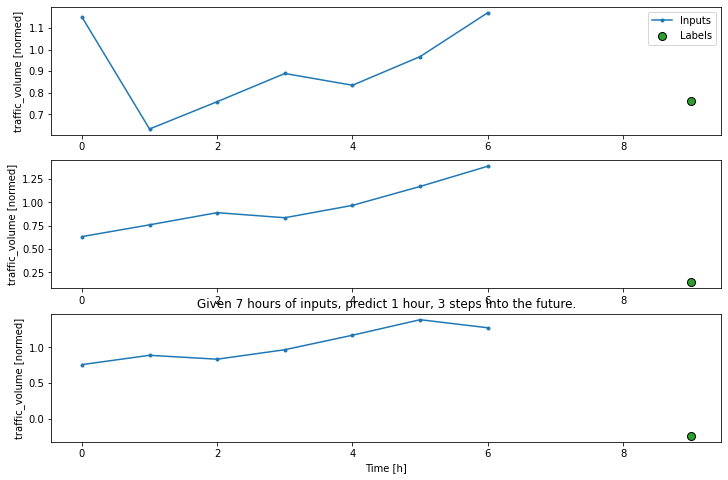

In [32]:
conv_window.plot()
plt.title("Given 7 hours of inputs, predict 1 hour, 3 steps into the future.")

Initiating the model

In [33]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=126,
                           kernel_size=(CONV_WIDTH,),
                           activation='tanh'),
    tf.keras.layers.Dense(units=63, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=1),
])


In [34]:
# ER Confirming the shape of the input and output window
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 7, 5)
Output shape: (32, 1, 1)


In [35]:
# ER compiling and fitting the model
history = compile_and_fit(conv_model, conv_window)


Epoch 1/20
858/858 [==============================] - 6s 6ms/step - loss: 0.4066 - mean_absolute_error: 0.4701 - val_loss: 0.1954 - val_mean_absolute_error: 0.3246
Epoch 2/20
858/858 [==============================] - 6s 7ms/step - loss: 0.3150 - mean_absolute_error: 0.3976 - val_loss: 0.1830 - val_mean_absolute_error: 0.3060
Epoch 3/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2907 - mean_absolute_error: 0.3752 - val_loss: 0.1656 - val_mean_absolute_error: 0.2829
Epoch 4/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2743 - mean_absolute_error: 0.3596 - val_loss: 0.1576 - val_mean_absolute_error: 0.2721
Epoch 5/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2632 - mean_absolute_error: 0.3501 - val_loss: 0.1525 - val_mean_absolute_error: 0.2648
Epoch 6/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2543 - mean_absolute_error: 0.3423 - val_loss: 0.1462 - val_mean_absolute_error: 0.2562
Epoch 7/20
858/8

In [36]:
# Getting performance
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=1)

156/156 [==============================] - 1s 4ms/step - loss: 0.1047 - mean_absolute_error: 0.2121


### Exporting Results
To export the results for use in the kaggle competition, I had to slice out the predictions for the test set. 

Once those were defined, I de-normalized them. To do this, I made the opposite transformations relative to what we did in the normalization step.

I then created a dataframe with an index that started at 1, and the predictions.

In [37]:
# ER Reversing Normalization
conv_pred = conv_model.predict(conv_window.test)[:,:,-1]
conv_pred = conv_pred * train_std['traffic_volume']
conv_pred = conv_pred + train_mean['traffic_volume']


In [38]:
# ER confirming shape
conv_pred.shape

(4991, 1)

In [39]:
# Er creating DataFrame
prediction_index = np.arange(1,4992)
prediction_list = pd.DataFrame(np.column_stack([prediction_index,conv_pred]),
                               columns = ['id','prediction'])
prediction_list.head(10)

,id,prediction
0,1.0,5648.123047
1,2.0,4963.490234
2,3.0,4618.261230
3,4.0,4658.171875
4,5.0,4730.620117
5,6.0,4161.218750
6,7.0,3359.797852
7,8.0,3115.092285
8,9.0,4149.109375
9,10.0,5021.633789


In [40]:
# ER exporting to csv
prediction_list.to_csv('Evelina_Results_Conv_final.csv', sep=',')

### RNN/LSTM
I attempted a single-layer, as well as a 2-layer and 3 layer variant of this model. I chose to work more on the  CNN becasue the performance of the LSTM model was much weaker. 

In [41]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(160, return_sequences=True),
    tf.keras.layers.LSTM(62, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [42]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', lstm_model(w1.example[0]).shape)

Input shape: (32, 7, 5)
Output shape: (32, 7, 1)


In [43]:
history = compile_and_fit(lstm_model, w1)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance['LSTM'] = lstm_model.evaluate(w1.test)

156/156 [==============================] - 2s 12ms/step - loss: 0.4096 - mean_absolute_error: 0.4003
